# Impute to actual missing values and Simulated holes

In [1]:
# import libraries

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.neural_network import MLPRegressor

from scipy.spatial import distance
from shapely.geometry import MultiPolygon, Polygon, Point


In [2]:
# import datasets

ESA_nonmissing = gpd.read_file('ESA_nonmissing.gpkg')
ESA_missing = gpd.read_file('ESA_missing.gpkg')

print(ESA_nonmissing.shape[0], ESA_missing.shape[0])

4719 1287


## Imputed data

In [3]:
target1 = 'CapacityRating'
target2 = 'peakload'

conti_features = ['Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 'Consumption_postcode', 
                  'Population_building', 'building_density_number', 'All building_num']

In [4]:
## Split into features and target
# Normalise targets
scaler_y1 = StandardScaler()
CR_scaled = scaler_y1.fit_transform(ESA_nonmissing[[target1]])

scaler_y2 = StandardScaler()
PL_scaled = scaler_y2.fit_transform(ESA_nonmissing[[target2]])

# Normalize continuous features
scaler_X = StandardScaler()
nonmissing_features_scaled = scaler_X.fit_transform(ESA_nonmissing[conti_features])
missing_features_scaled = scaler_X.transform(ESA_missing[conti_features])

In [5]:
# Citation: Scikit-learn, MLPRegressor. 
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

# Function to perform MLP Imputation
def impute_mlp_impute(target, scaler_y, hiddensizes, lr):
    
    mlp = MLPRegressor(hidden_layer_sizes=hiddensizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=363, early_stopping=True, validation_fraction=0.1, 
                       learning_rate_init=lr)
    
    # Train the model
    mlp.fit(nonmissing_features_scaled, target.ravel())
    
    # Predict on test data
    y_pred_scaled = mlp.predict(missing_features_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return y_pred

# Apply the MLP imputer in capacity rating and peakload
CR_impute = impute_mlp_impute(CR_scaled, scaler_y1, (30, 30), 0.05)
PL_impute = impute_mlp_impute(PL_scaled, scaler_y2, (5, 5), 0.05)

In [6]:
ESA_imputed = ESA_missing.copy()
ESA_imputed['CapacityRating'] = CR_impute
ESA_imputed['peakload'] = PL_impute
ESA_imputed['Headroom'] = ESA_imputed['CapacityRating'] - ESA_imputed['peakload']
ESA_imputed['% headroom'] = ESA_imputed['Headroom'] / ESA_imputed['CapacityRating'] * 100

In [7]:
ESA_completed = pd.concat([ESA_nonmissing, ESA_imputed])

### non-missing, imputed, completed dataset compared

In [8]:
# statistic summary for capacity rating
print(ESA_nonmissing[target1].describe())
print(ESA_imputed[target1].describe())
print(ESA_completed[target1].describe())

count    4719.000000
mean      271.246239
std       254.532140
min         1.000000
25%        50.000000
50%       200.000000
75%       500.000000
max      1500.000000
Name: CapacityRating, dtype: float64
count    1287.000000
mean      266.580841
std       212.439830
min        86.534216
25%       105.291360
50%       150.690785
75%       406.418810
max      1045.782984
Name: CapacityRating, dtype: float64
count    6006.000000
mean      270.246511
std       246.109882
min         1.000000
25%        94.681401
50%       200.000000
75%       500.000000
max      1500.000000
Name: CapacityRating, dtype: float64


In [9]:
# statistic summary for peak load
print(ESA_nonmissing[target2].describe())
print(ESA_imputed[target2].describe())
print(ESA_completed[target2].describe())

count    4719.000000
mean       94.894139
std       108.393776
min         0.000000
25%        10.875000
50%        51.720000
75%       149.385000
max       827.450000
Name: peakload, dtype: float64
count    1287.000000
mean       70.687040
std        75.054971
min         8.442514
25%        16.202336
50%        32.030751
75%       114.424775
max       665.647718
Name: peakload, dtype: float64
count    6006.000000
mean       89.706903
std       102.645838
min         0.000000
25%        12.880803
50%        46.985488
75%       140.230000
max       827.450000
Name: peakload, dtype: float64


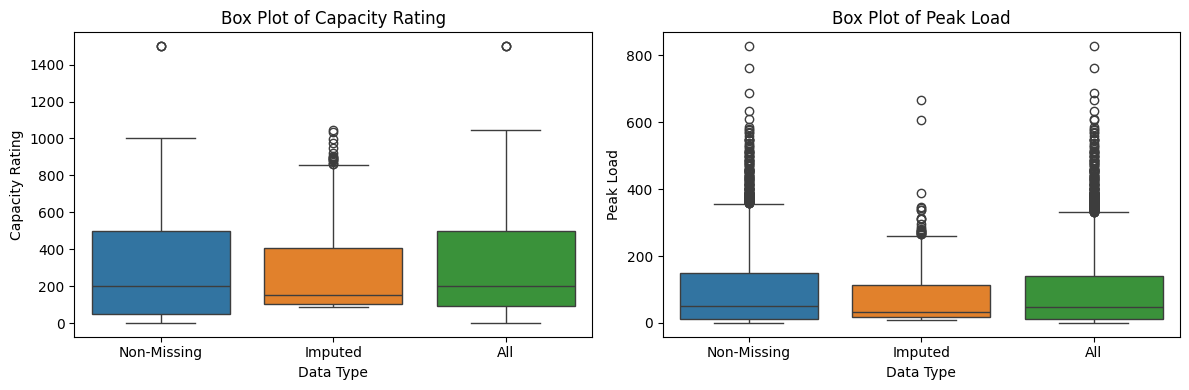

In [10]:
target1 = 'CapacityRating'
target2 = 'peakload'

# Prepare data for plotting
non_missing_data = ESA_nonmissing[[target1, target2]].copy()
non_missing_data['Type'] = 'Non-Missing'

imputed_data = ESA_imputed[[target1, target2]].copy()
imputed_data['Type'] = 'Imputed'

all_data = ESA_completed[[target1, target2]].copy()
all_data['Type'] = 'All'

# Combine the data into one DataFrame
combined_data = pd.concat([non_missing_data, imputed_data, all_data])

# Create the box plot
plt.figure(figsize=(12, 4))

# Plot for Capacity Rating
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y=target1, data=combined_data, hue='Type')
plt.title('Box Plot of Capacity Rating')
plt.xlabel('Data Type')
plt.ylabel('Capacity Rating')

# Plot for Peak Load
plt.subplot(1, 2, 2)
sns.boxplot(x='Type', y=target2, data=combined_data, hue='Type')
plt.title('Box Plot of Peak Load')
plt.xlabel('Data Type')
plt.ylabel('Peak Load')

plt.tight_layout()
plt.show()

In [11]:
# statistics summary for headroom %
target = '% headroom'

print(ESA_nonmissing[target].describe())
print(ESA_imputed[target].describe())
print(ESA_completed[target].describe())

count    4719.000000
mean       58.528671
std       113.234052
min     -5818.080000
25%        47.005000
50%        68.880000
75%        85.655000
max       100.000000
Name: % headroom, dtype: float64
count    1287.000000
mean       76.843408
std        11.883592
min        27.622959
25%        67.316046
50%        81.021786
75%        86.407571
max        93.492501
Name: % headroom, dtype: float64
count    6006.000000
mean       62.453258
std       100.800098
min     -5818.080000
25%        53.502500
50%        72.472183
75%        86.028956
max       100.000000
Name: % headroom, dtype: float64


## Compare to PESA

In [12]:
# PESA dataset
gpkg_file_path = 'OCC_Primary_Substations_ESAs.gpkg'
PESA = gpd.read_file(gpkg_file_path)
PESA.replace(-123456, np.nan, inplace=True)

# calculate peakload
PESA['Firm peakload'] = PESA['Firm Capacity'] - PESA['Demand Headroom (MVA)']

# Re-project to the projected CRS
projected_crs = "EPSG:3395"
PESA_projected = PESA.to_crs(projected_crs)

# area calculation
PESA_projected['area_PESA'] = PESA_projected.geometry.area

# Display the first few rows of the dataframe
print(PESA_projected.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   DNO                    68 non-null     object  
 1   Substation ID          68 non-null     int32   
 2   Substation Name        68 non-null     object  
 3   Demand Headroom (MVA)  66 non-null     float64 
 4   Firm Capacity Summer   65 non-null     float64 
 5   Firm Capacity WInter   66 non-null     float64 
 6   Firm Capacity          66 non-null     float64 
 7   Demand Headroom %      68 non-null     object  
 8   Latitude               64 non-null     float64 
 9   Longitude              64 non-null     float64 
 10  geometry               68 non-null     geometry
 11  Firm peakload          66 non-null     float64 
 12  area_PESA              68 non-null     float64 
dtypes: float64(8), geometry(1), int32(1), object(3)
memory usage: 6.8+ KB
None


In [13]:
# merge imputed ESA with PESA
# Re-project to the projected CRS
projected_crs = "EPSG:3395"
ESA_completed_projected = ESA_completed.to_crs(projected_crs)

# area calculation
ESA_completed_projected['area_ESA'] = ESA_completed_projected.geometry.area
# ESA_projected.head()
ESA_completed_projected.head()

joined_gdf = gpd.sjoin(ESA_completed_projected, PESA_projected, how="left", predicate='intersects')
joined_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8083 entries, 0 to 1286
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   SEC_SUB_NUMBER                       6316 non-null   object  
 1   SEC_SUB_NAME                         6310 non-null   object  
 2   Area                                 6316 non-null   object  
 3   DNO_left                             8083 non-null   object  
 4   Flag_SubDesign                       6316 non-null   object  
 5   CapacityRating                       8083 non-null   float64 
 6   peakload                             8083 non-null   float64 
 7   Headroom                             8083 non-null   float64 
 8   % headroom                           8083 non-null   float64 
 9   Demand_rag                           8083 non-null   object  
 10  latitude                             6249 non-null   float64 
 11  longitude     

In [14]:
# Citation: Nestler, J. B. (2020, August 17). How to find geometry intersections within the same dataset using GeoPandas. Medium. 
# https://medium.com/@jesse.b.nestler/how-to-find-geometry-intersections-within-the-same-dataset-using-geopandas-59cd1a5f30f9
# Calculate intersection areas
def calculate_intersection(row):
    if pd.notnull(row['index_right']):
        intersected_geometry = row.geometry.intersection(PESA_projected.loc[row['index_right']].geometry)
        return intersected_geometry
    else:
        return None

joined_gdf['intersection'] = joined_gdf.apply(calculate_intersection, axis=1)

# Calculate area of intersections
joined_gdf['intersection_area'] = joined_gdf['intersection'].apply(lambda x: x.area if x else 0)
joined_gdf['intersection_percent_ESA'] = joined_gdf['intersection_area']/joined_gdf['area_ESA']

joined_gdf['sum_intersection_percent_ESA'] = joined_gdf.groupby(joined_gdf.index)['intersection_percent_ESA'].transform('sum')
joined_gdf['weight'] = joined_gdf['intersection_percent_ESA']/joined_gdf['sum_intersection_percent_ESA']

In [15]:
joined_gdf['missing_num'] = joined_gdf['missing'].map({'Missing': 1, 'Non-Missing': 0})

joined_gdf['predict_peakload'] = joined_gdf['peakload']*joined_gdf['weight']
joined_gdf['imputed_peakload'] = joined_gdf['peakload']*joined_gdf['weight']*joined_gdf['missing_num']

agg_data = joined_gdf[['predict_peakload', 'imputed_peakload']]/1000
predict_peakload = agg_data.groupby(joined_gdf['index_right']).sum()
predict_peakload.describe()

,predict_peakload,imputed_peakload
count,68.000000,68.000000
mean,6.441959,0.668917
std,5.378327,1.179679
min,0.005845,0.000002
25%,1.887013,0.086830
50%,5.897947,0.254012
75%,8.825762,0.668785
max,22.168123,5.821801


In [16]:
# Calculate the percentage of missing values in each PESA
total_missing = joined_gdf.groupby('index_right')['missing_num'].sum() # total missing data points in each PESA
total_entries = joined_gdf.groupby('index_right')['missing_num'].count() # total data points in each PESA
missing_percentage = (total_missing / total_entries) * 100 # Calculate missing percentage
missing_percentage = missing_percentage.reset_index(name='missing_percentage') # Reset the index

missing_percentage.describe()

,index_right,missing_percentage
count,68.00000,68.000000
mean,33.50000,22.525447
std,19.77372,16.794322
min,0.00000,3.125000
25%,16.75000,12.806874
50%,33.50000,16.666667
75%,50.25000,25.753083
max,67.00000,71.264368


In [17]:
# Calculate the difference and nonmissing peak load for later plotting
PESA_ESA_imputed = pd.concat([PESA_projected, predict_peakload, missing_percentage], axis=1)
PESA_ESA_imputed['% peakload_difference'] = (PESA_ESA_imputed['Firm peakload']-PESA_ESA_imputed['predict_peakload'])/PESA_ESA_imputed['Firm peakload']*100
PESA_ESA_imputed['nonmissing_peakload'] = PESA_ESA_imputed['predict_peakload']-PESA_ESA_imputed['imputed_peakload']
PESA_ESA_imputed['% actual peakload difference'] = (PESA_ESA_imputed['Firm peakload']-PESA_ESA_imputed['nonmissing_peakload'])/PESA_ESA_imputed['Firm peakload']*100

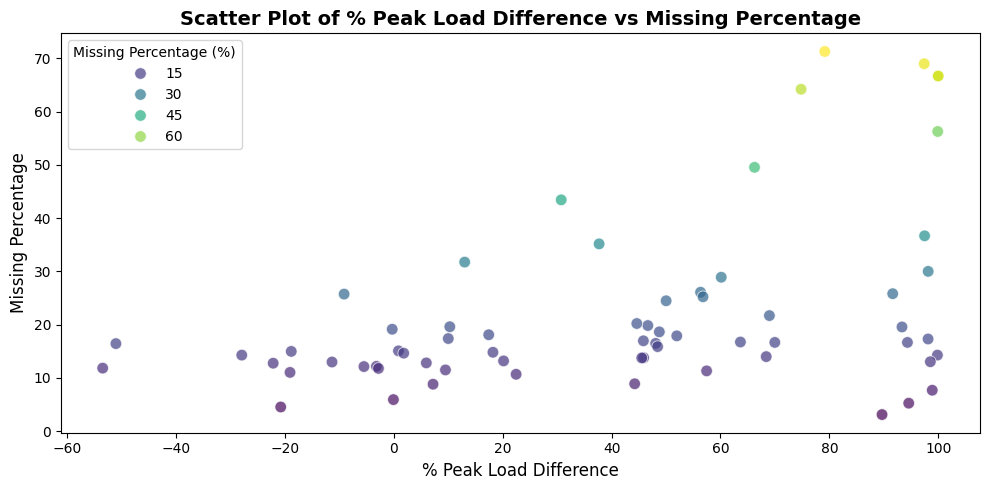

In [18]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Create the scatter plot
scatter_plot = sns.scatterplot(data=PESA_ESA_imputed, x='% actual peakload difference', y='missing_percentage',
                               hue='missing_percentage', palette='viridis', s=70, alpha=0.7)

# Add a title and labels
plt.title('Scatter Plot of % Peak Load Difference vs Missing Percentage', fontsize=14, fontweight='bold')
plt.xlabel('% Peak Load Difference', fontsize=12)
plt.ylabel('Missing Percentage', fontsize=12)

# Customize the legend
legend = scatter_plot.get_legend()
legend.set_title('Missing Percentage (%)')

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/5d/7th82vpd7gj_dmjspx03cm9m0000gn/T/ipykernel_43208/1079793122.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=PESA_ESA_imputed, x='missing_bins', y='% peakload_difference', palette='coolwarm')


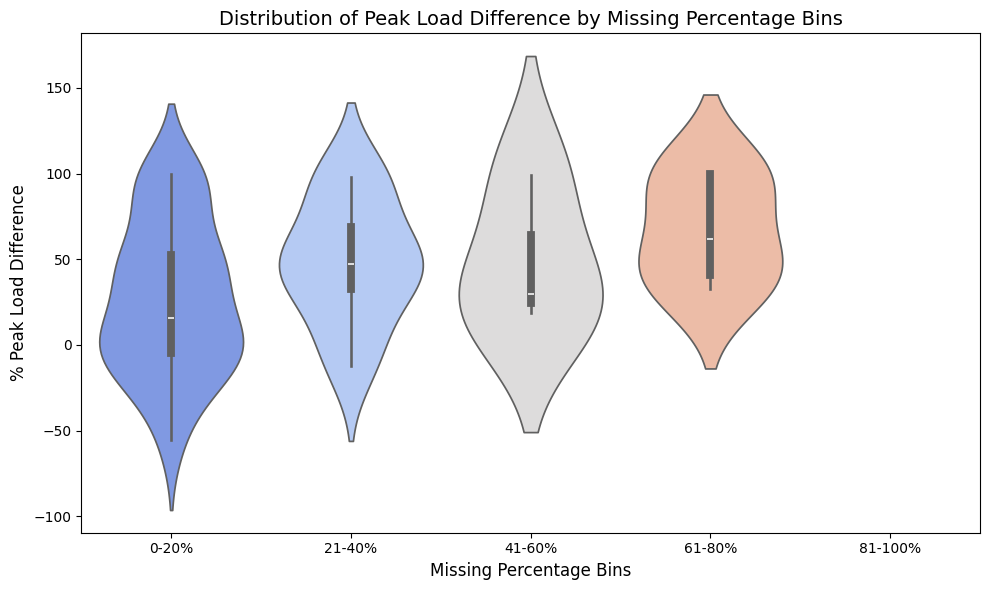

In [19]:
## try violin plot
# Create bins for missing_percentage
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
PESA_ESA_imputed['missing_bins'] = pd.cut(PESA_ESA_imputed['missing_percentage'], bins=bins, labels=labels)

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=PESA_ESA_imputed, x='missing_bins', y='% peakload_difference', palette='coolwarm')

# Add title and labels
plt.title('Distribution of Peak Load Difference by Missing Percentage Bins', fontsize=14)
plt.xlabel('Missing Percentage Bins', fontsize=12)
plt.ylabel('% Peak Load Difference', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

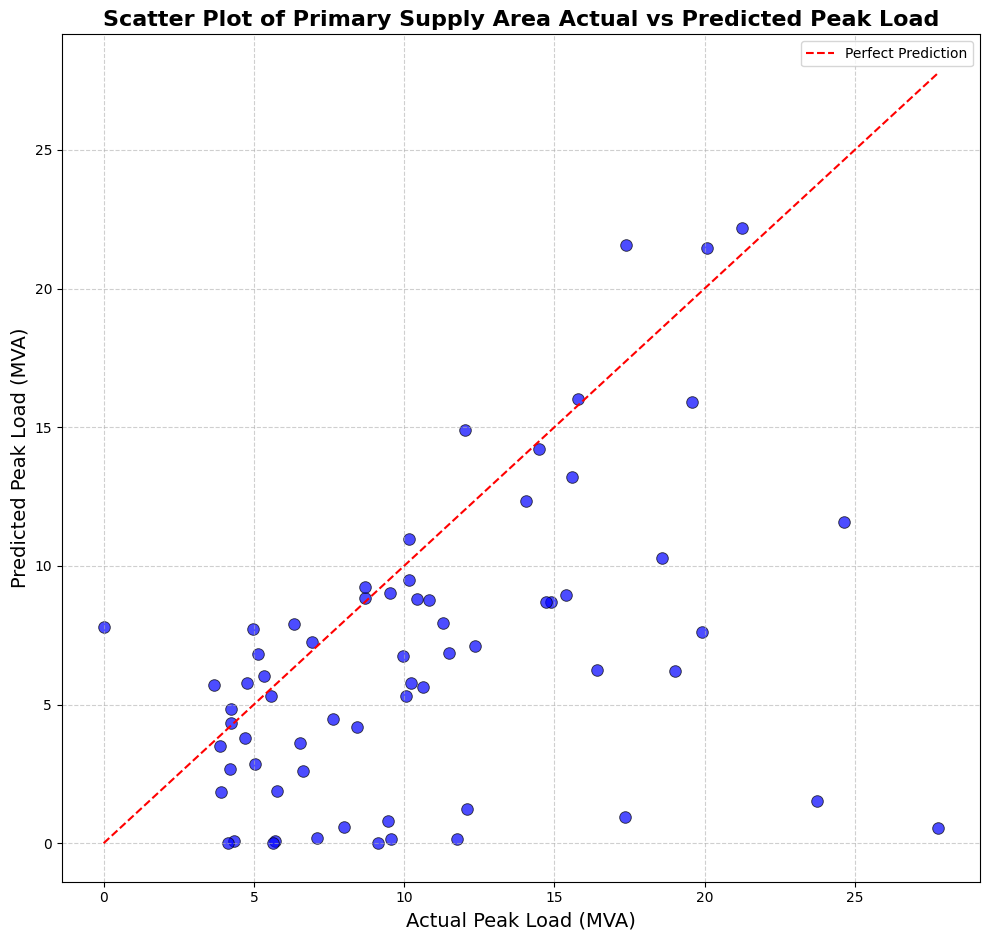

In [20]:
## compare between Firm and predict peak load
# Create the scatter plot
plt.figure(figsize=(10, 9.5))

# Scatter plot
sns.scatterplot(data=PESA_ESA_imputed, x='Firm peakload', y='predict_peakload', 
                color='blue', edgecolor='black', alpha=0.7, s=70)

# Add a diagonal reference line (y = x)
plt.plot([PESA_ESA_imputed['Firm peakload'].min(), PESA_ESA_imputed['Firm peakload'].max()], 
         [PESA_ESA_imputed['Firm peakload'].min(), PESA_ESA_imputed['Firm peakload'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')

# Add title and labels
plt.title('Scatter Plot of Primary Supply Area Actual vs Predicted Peak Load', fontsize=16, fontweight='bold')
plt.xlabel('Actual Peak Load (MVA)', fontsize=14)
plt.ylabel('Predicted Peak Load (MVA)', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Example for simulate missing values with spatial holes

In [21]:
# Citation: GeoPandas Documentation, Geometric manipulations. 
# https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html

def create_holes(gdf, num_holes, hole_radius, random_seed=42):
    np.random.seed(random_seed)
    
    # Make a copy to create holes in dataset
    gdf_with_holes = gdf.copy()
    
    # Extract centroids of multipolygons
    centroids = gdf_with_holes['geometry'].apply(lambda geom: geom.centroid)
    
    for _ in range(num_holes):
        # Randomly select few points as the center of the holes
        idx = np.random.choice(gdf_with_holes.index)
        hole_center = centroids[idx]
        
        # Create a circular hole with provided radius
        hole = hole_center.buffer(hole_radius)
        
        # Ensure the hole is valid and not empty
        if hole.is_empty:
            continue
        
        # Find geometries that intersecting with the hole
        intersecting = gdf_with_holes['geometry'].intersects(hole)
        
        # Set these data points to NaN in both targets (simulate missing data)
        gdf_with_holes.loc[intersecting, 'CapacityRating'] = np.nan
        gdf_with_holes.loc[intersecting, 'peakload'] = np.nan
    
    return gdf_with_holes

# Apply the function to create holes
ESA_with_holes = create_holes(ESA_nonmissing, num_holes=5, hole_radius=0.04, random_seed=29)

# Calculate the number simulated missing data points
print("Number of NaNs in targets with 5 holes and r=0.04:", ESA_with_holes['CapacityRating'].isna().sum())

Number of NaNs in targets with 5 holes and r=0.04: 602


In [22]:
target1 = 'CapacityRating'
target2 = 'peakload'

conti_features = ['Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 'Consumption_postcode', 
                   'Population_building', 'building_density_number', 'All building_num']

In [23]:
# Separate the rows with and without missing values
non_missing_data = ESA_with_holes.dropna(subset=['CapacityRating'])  # Rows without holes (non-missing)
missing_data = ESA_with_holes[ESA_with_holes['CapacityRating'].isna()]  # Rows with holes (missing)

## Split into features and target
# Normalise targets
scaler_y1 = StandardScaler()
CR_scaled = scaler_y1.fit_transform(non_missing_data[[target1]])
scaler_y2 = StandardScaler()
PL_scaled = scaler_y2.fit_transform(non_missing_data[[target2]])

# Normalize continuous features
scaler_X = StandardScaler()
nonmissing_features_scaled = scaler_X.fit_transform(non_missing_data[conti_features])
missing_features_scaled = scaler_X.transform(missing_data[conti_features])

In [24]:
# Function to perform MLP Imputation
def impute_mlp_holes(target, scaler_y, hiddensizes, lr):
    
    mlp = MLPRegressor(hidden_layer_sizes=hiddensizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=363, early_stopping=True, validation_fraction=0.1, 
                       learning_rate_init=lr)
    
    # Train the model
    mlp.fit(nonmissing_features_scaled, target.ravel())
    
    # Predict on test data
    y_pred_scaled = mlp.predict(missing_features_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return y_pred

# Apply the MLP
CR_impute = impute_mlp_holes(CR_scaled, scaler_y1, (30, 30), 0.05)
PL_impute = impute_mlp_holes(PL_scaled, scaler_y2, (5, 5), 0.05)

In [25]:
def compare_df(gdf_with_holes, imputed_df, target):
    
    missing_mask = np.isnan(gdf_with_holes[target])

    # Evaluate imputation
    missing_indices = gdf_with_holes.index[missing_mask]
    original_values = ESA_nonmissing.loc[missing_indices, target]
    geometry = ESA_nonmissing.loc[missing_indices, 'geometry']

    comparison_df = gpd.GeoDataFrame({
        'Original': original_values,
        'Imputed': imputed_df.flatten(),
        'geometry': geometry
    })

    return comparison_df

compare_CR = compare_df(ESA_with_holes ,CR_impute, target1)
compare_PL = compare_df(ESA_with_holes ,PL_impute, target2)

In [26]:
def evaluate_imputation_CR(original, imputed):
    rmse = np.sqrt(mean_squared_error(original, imputed))
    mae = mean_absolute_error(original, imputed)
    mape = mean_absolute_percentage_error(original, imputed)*100
    return rmse, mae, mape

def evaluate_imputation_PL(original, imputed):
    rmse = np.sqrt(mean_squared_error(original, imputed))
    mae = mean_absolute_error(original, imputed)
    mape = mean_absolute_percentage_error(original+1, imputed)*100 # to avoid -inf
    return rmse, mae, mape

rmse_CR, mae_CR, mape_CR = evaluate_imputation_CR(compare_CR['Original'], compare_CR['Imputed'])
rmse_PL, mae_PL, mape_PL = evaluate_imputation_PL(compare_PL['Original'], compare_PL['Imputed'])

# Print results
print(f"RMSE (CR)  : {rmse_CR}")
print(f"MAE  (CR)  : {mae_CR}")
print(f"MAPE (CR)  : {mape_CR}")
print(" ")
print(f"RMSE (PL)  : {rmse_PL}")
print(f"MAE  (PL)  : {mae_PL}")
print(f"MAPE (PL)  : {mape_PL}")

RMSE (CR)  : 170.43285008386428
MAE  (CR)  : 116.51700933608853
MAPE (CR)  : 103.09546772123812
 
RMSE (PL)  : 69.35621450681263
MAE  (PL)  : 46.2985656467755
MAPE (PL)  : 140.77710600260636
